# [Dacon_2023 전력사용량 예측 AI 경진대회](https://dacon.io/competitions/official/236125/overview/description)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import time
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings('ignore')

## 데이터 불러오기 및 결합(join)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/powerage/train.csv')
building = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/powerage/building_info.csv', na_values='-')
display(train.head(3))
display(building.head(3))
print(train.shape)
print(building.shape)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88


,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.0,NaN,NaN,NaN
1,2,건물기타,122233.47,99000.0,NaN,NaN,NaN
2,3,건물기타,171243.00,113950.0,40.0,NaN,NaN


(204000, 10)
(100, 7)


In [14]:
df = train.merge(building, on='건물번호').drop('num_date_time', axis=1)
display(df.head())
print(df.shape)
print(df.info())

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,건물기타,110634.0,39570.0,NaN,NaN,NaN
1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,건물기타,110634.0,39570.0,NaN,NaN,NaN
2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,건물기타,110634.0,39570.0,NaN,NaN,NaN
3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,건물기타,110634.0,39570.0,NaN,NaN,NaN
4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,건물기타,110634.0,39570.0,NaN,NaN,NaN


(204000, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   건물번호          204000 non-null  int64  
 1   일시            204000 non-null  object 
 2   기온(C)         204000 non-null  float64
 3   강수량(mm)       43931 non-null   float64
 4   풍속(m/s)       203981 non-null  float64
 5   습도(%)         203991 non-null  float64
 6   일조(hr)        128818 non-null  float64
 7   일사(MJ/m2)     116087 non-null  float64
 8   전력소비량(kWh)    204000 non-null  float64
 9   건물유형          204000 non-null  object 
 10  연면적(m2)       204000 non-null  float64
 11  냉방면적(m2)      204000 non-null  float64
 12  태양광용량(kW)     73440 non-null   float64
 13  ESS저장용량(kWh)  10200 non-null   float64
 14  PCS용량(kW)     10200 non-null   float64
dtypes: float64(12), int64(1), object(2)
memory usage: 24.9+ MB
None


## 전처리 및 EDA

In [ ]:
# 결측치 비율
df.isna().sum() / len(df)

건물번호            0.000000
일시              0.000000
기온(C)           0.000000
강수량(mm)         0.784652
풍속(m/s)         0.000093
습도(%)           0.000044
일조(hr)          0.368539
일사(MJ/m2)       0.430946
전력소비량(kWh)      0.000000
건물유형            0.000000
연면적(m2)         0.000000
냉방면적(m2)        0.000000
태양광용량(kW)       0.640000
ESS저장용량(kWh)    0.950000
PCS용량(kW)       0.950000
dtype: float64

In [15]:
# 결측치 비율이 0.5 이상인 칼럼 제거
df.drop(['강수량(mm)',  '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1, inplace=True)

# 결측치 대체
df.fillna(df.mean(), inplace=True)
df.isna().sum()

건물번호          0
일시            0
기온(C)         0
풍속(m/s)       0
습도(%)         0
일조(hr)        0
일사(MJ/m2)     0
전력소비량(kWh)    0
건물유형          0
연면적(m2)       0
냉방면적(m2)      0
dtype: int64

In [16]:
# 일시 컬럼을 datetime 형식으로 변환
def to_dt(x):
    return x[:4] + '-' + x[4:6] + '-' + x[6:8] + ' ' + x[9:11] + ':00:00'

df['datetime'] = pd.to_datetime(df['일시'].apply(to_dt))
df.drop('일시', axis=1, inplace=True)
df.head(3)

# 날짜 정보 컬럼 생성
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   건물번호        204000 non-null  int64         
 1   기온(C)       204000 non-null  float64       
 2   풍속(m/s)     204000 non-null  float64       
 3   습도(%)       204000 non-null  float64       
 4   일조(hr)      204000 non-null  float64       
 5   일사(MJ/m2)   204000 non-null  float64       
 6   전력소비량(kWh)  204000 non-null  float64       
 7   건물유형        204000 non-null  object        
 8   연면적(m2)     204000 non-null  float64       
 9   냉방면적(m2)    204000 non-null  float64       
 10  datetime    204000 non-null  datetime64[ns]
 11  year        204000 non-null  int64         
 12  month       204000 non-null  int64         
 13  day         204000 non-null  int64         
 14  hour        204000 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(5), object(

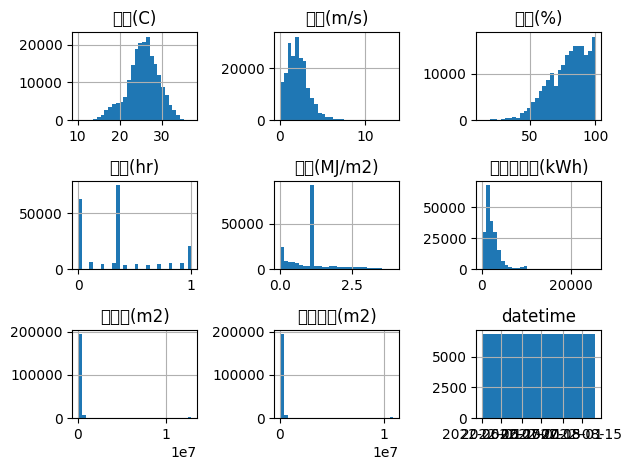

In [17]:
# 연속형 변수 히스토그램
df.drop(['건물번호', 'year', 'month', 'day', 'hour'],axis=1).hist(bins=30);
plt.tight_layout()

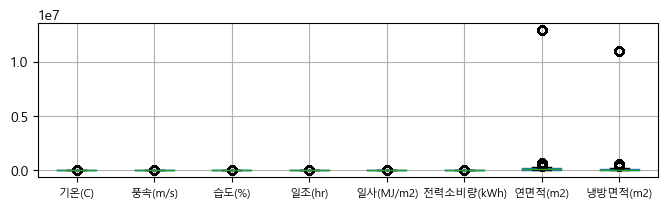

In [ ]:
# 연속형 변수 상자그림
plt.figure(figsize=(8,2))
df.drop(['건물번호', 'year', 'month', 'day', 'hour'],axis=1).boxplot()
plt.xticks(fontsize=8);

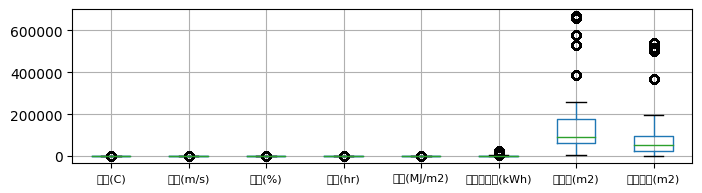

In [18]:
# 이상치 제거
df.loc[df['연면적(m2)']== df['연면적(m2)'].max(), '연면적(m2)'] = np.median(df['연면적(m2)'])
df.loc[df['냉방면적(m2)']== df['냉방면적(m2)'].max(), '냉방면적(m2)'] = np.median(df['냉방면적(m2)'])
plt.figure(figsize=(8,2))
df.drop(['건물번호', 'year', 'month', 'day', 'hour'],axis=1).boxplot();
plt.xticks(fontsize=8);

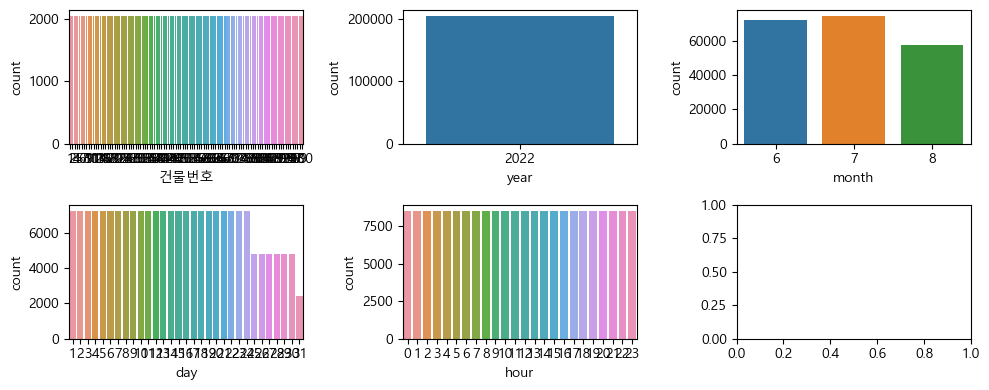

In [ ]:
# 범주형 변수 막대그래프
cate_col = ['건물번호', 'year', 'month', 'day', 'hour']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for i, feature in zip(range(5), cate_col):
    row = int(i/3)
    col = i % 3
    sns.countplot(data=df, x=feature, ax=ax[row][col])
plt.tight_layout()

In [ ]:
df['건물번호'].value_counts().values
df['day'].value_counts().values
df['hour'].value_counts().values
df['month'].value_counts().values

array([74400, 72000, 57600], dtype=int64)

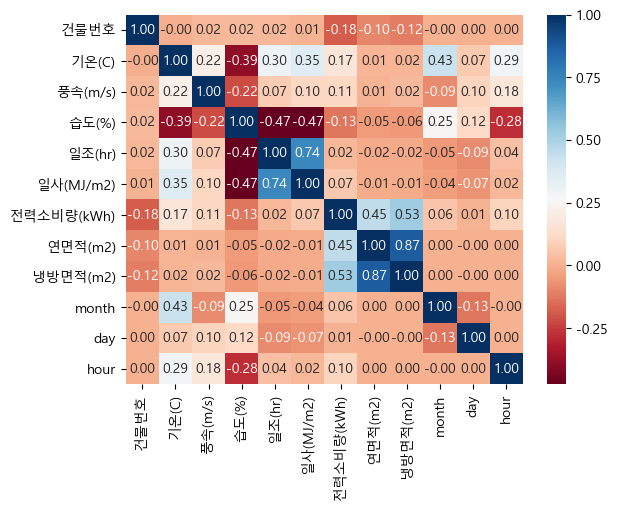

In [ ]:
df_corr = df.drop('year', axis=1).corr()
sns.heatmap(df_corr, annot=True, cmap='RdBu', fmt='.2f');

- 다중공선성 의심 변수
    - 일조 ~ 일사
    - 연면적 ~ 냉방면적

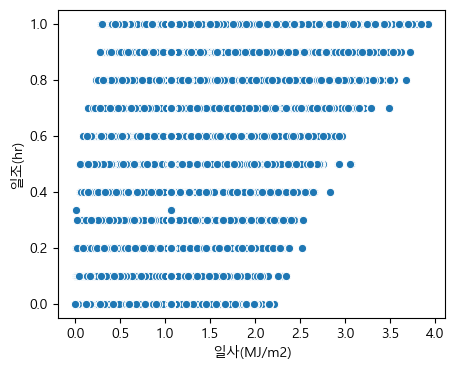

In [ ]:
# 일조 ~ 일사
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, y='일조(hr)', x='일사(MJ/m2)');

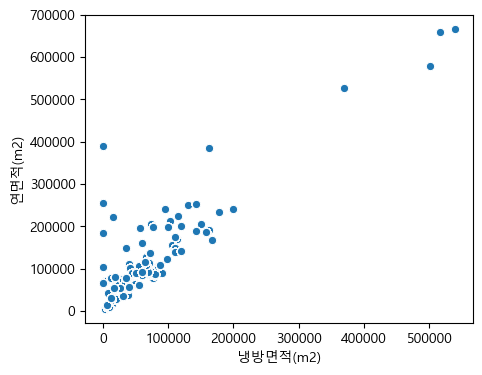

In [ ]:
# 연면적 ~ 냉방면적
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, y='연면적(m2)', x='냉방면적(m2)');

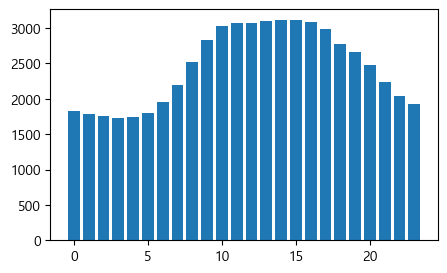

In [ ]:
# 시간에 따른 평균 전력소비량
hour_power = df[['hour', '전력소비량(kWh)']].groupby(['hour'], as_index=False).mean()
plt.figure(figsize=(5,3))
plt.bar(data=hour_power, x='hour', height='전력소비량(kWh)');

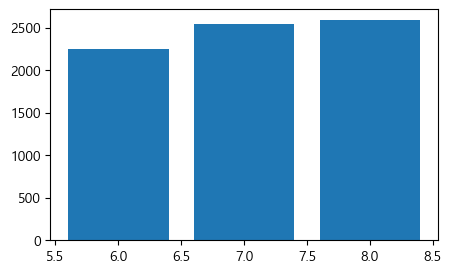

In [ ]:
# 월에 따른 평균 전력소비량
month_power = df[['month', '전력소비량(kWh)']].groupby(['month'], as_index=False).mean()
plt.figure(figsize=(5,3))
plt.bar(data=month_power, x='month', height='전력소비량(kWh)');

In [ ]:
df.head(3)

,건물번호,기온(C),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),datetime,year,month,day,hour
0,1,18.6,0.9,42.0,0.333637,1.063823,1085.28,건물기타,110634.0,39570.0,2022-06-01 00:00:00,2022,6,1,0
1,1,18.0,1.1,45.0,0.333637,1.063823,1047.36,건물기타,110634.0,39570.0,2022-06-01 01:00:00,2022,6,1,1
2,1,17.7,1.5,45.0,0.333637,1.063823,974.88,건물기타,110634.0,39570.0,2022-06-01 02:00:00,2022,6,1,2


In [19]:
# 불필요한 컬럼 제거
df1 = df.drop(['건물번호', 'day', 'hour', 'year', 'datetime', '건물유형'], axis=1)
df1.head(3)

,기온(C),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연면적(m2),냉방면적(m2),month
0,18.6,0.9,42.0,0.333637,1.063823,1085.28,110634.0,39570.0,6
1,18.0,1.1,45.0,0.333637,1.063823,1047.36,110634.0,39570.0,6
2,17.7,1.5,45.0,0.333637,1.063823,974.88,110634.0,39570.0,6


In [ ]:
df1.describe()

,기온(C),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연면적(m2),냉방면적(m2),month
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,25.543524,2.134031,78.716295,0.333637,1.063823,2451.036462,133085.163310,77542.020400,6.929412
std,3.779523,1.358045,15.079775,0.319038,0.755132,2440.648858,123485.290603,95387.582809,0.793923
min,10.100000,0.000000,13.000000,0.000000,0.000000,0.000000,5578.400000,0.000000,6.000000
25%,23.400000,1.200000,69.000000,0.000000,0.550000,1085.760000,61446.120000,23187.000000,6.000000
50%,25.700000,2.000000,81.000000,0.333637,1.063823,1766.400000,92303.750000,55705.040000,7.000000
75%,28.100000,2.800000,91.000000,0.333637,1.063823,2970.000000,176765.900000,96131.250000,8.000000
max,37.100000,13.300000,100.000000,1.000000,3.920000,25488.400000,667131.000000,539213.000000,8.000000


## 모델 구현

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 범주형 변수 원-핫 인코딩
le = LabelEncoder()
df1['month'] = le.fit_transform(df1['month'])

# 데이터 분할
X = df1.drop('전력소비량(kWh)', axis=1)
y = df1['전력소비량(kWh)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# 스케일링 성능 평가
def scaling(scaler, model):
    X_train_sc = scaler.fit_transform(X_train)
    scores = cross_val_score(model, X_train_sc, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -1 * scores
    avg_mse = round(np.mean(mse), 4)
    return print(f"평균 MAE :{avg_mse :.4f}")

In [12]:
scaling(StandardScaler(), ExtraTreesRegressor())

평균 MAE :292955.5822


In [13]:
scaling(RobustScaler(), ExtraTreesRegressor())

평균 MAE :292165.3179


In [14]:
scaling(MinMaxScaler(), ExtraTreesRegressor())

평균 MAE :292499.3021


In [21]:
# 스케일링
scaler = RobustScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

# 모델 객체 생성
rfr_reg = RandomForestRegressor(random_state=1234)
ext_reg = ExtraTreesRegressor(random_state=1234)
bag_reg = BaggingRegressor(random_state=1234)
xgb_reg = XGBRegressor(random_state=1234)
light_reg = LGBMRegressor(random_state=1234)

def SMAPE(true, pred):
  return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) #100은 상수이므로 이번 코드에서는 제외

# 모델 구현
def make_model(model, X_train_sc, X_test_sc):
  model.fit(X_train_sc, y_train)
  pred = model.predict(X_test_sc)
  smape = SMAPE(y_test, pred)
  print('SMAPE: ', round(smape, 4))

In [24]:
make_model(rfr_reg, X_train_sc, X_test_sc)

SMAPE:  0.1371


In [25]:
make_model(ext_reg, X_train_sc, X_test_sc)

SMAPE:  0.1386


In [26]:
make_model(bag_reg, X_train_sc, X_test_sc)

SMAPE:  0.1389


In [27]:
make_model(xgb_reg, X_train_sc, X_test_sc)

SMAPE:  0.1674


In [28]:
make_model(light_reg, X_train_sc, X_test_sc)

SMAPE:  0.1721


In [32]:
# 교차 검증
scores = -1 * cross_val_score(ext_reg , X_train_sc, y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print('교차 검증 MSE 값: ', scores)
print('평균 MSE 값: ', round(np.mean(scores), 4))

교차 검증 MSE 값:  [294782.2343798  304413.69905371 281732.8823194  286627.04131441
 298932.11878716]
평균 MSE 값:  293297.5952


In [34]:
# 그리드서치
param_grid = {
    'n_estimators':  [10, 20, 50, 100, 200, 500, 1000, 1200],
    'max_depth': [5, 8, 13, 21, 34, 53, 54, 55, 89, None],
    'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    'min_samples_leaf': [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
}

grid = GridSearchCV(ext_reg, param_grid = param_grid, cv=5)
grid.fit(X_train_sc, y_train)
# grid.best_estimator_
print(grid.best_params_)
cv_result = pd.DataFrame(grid.cv_results_)
cv_result.head()

ValueError: ignored